In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import os, cv2
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

In [61]:
DATA_DIR = '/content/drive/MyDrive/Task'

metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)

(5603, 623)

In [62]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
class_names = class_dict['name'].tolist()
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('All dataset classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

All dataset classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


In [63]:
select_classes = ['background', 'road']

select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Selected classes and their corresponding RGB values in labels:
Class Names:  ['road', 'background']
Class RGB values:  [[255, 255, 255], [0, 0, 0]]


In [64]:
def visualize(**images):

    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):

    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):

    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):

    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [65]:
class RoadsDataset(torch.utils.data.Dataset):

    def __init__(
            self,
            df,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)


        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')


        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']


        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_paths)

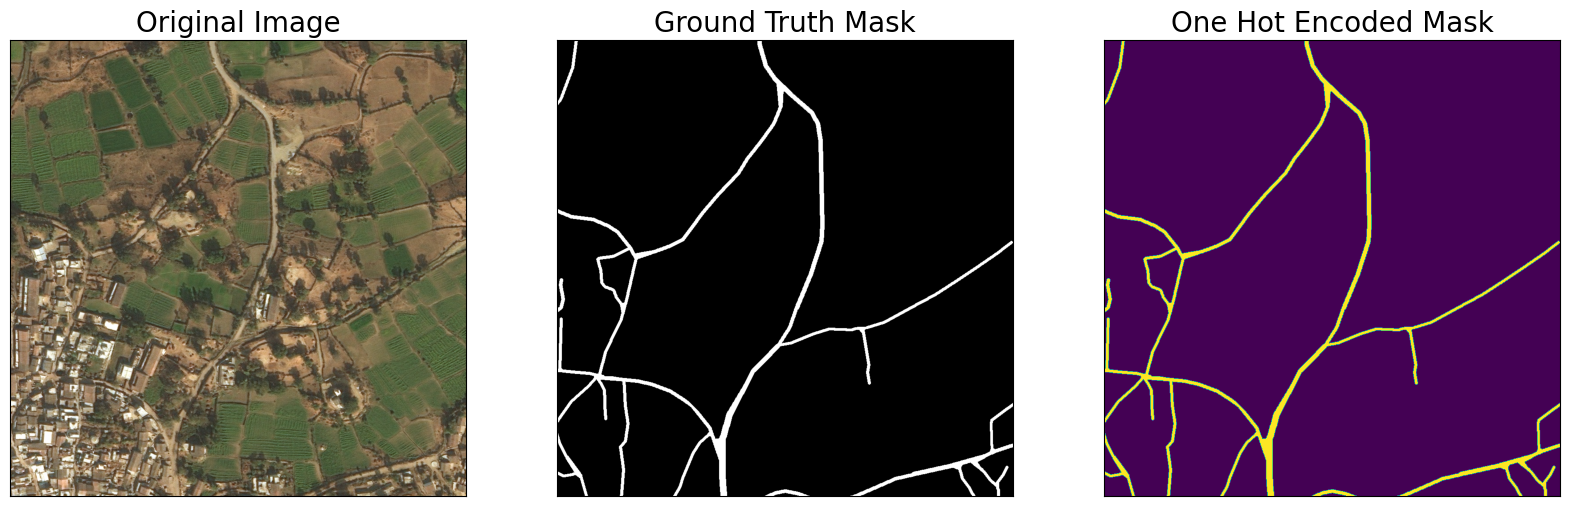

In [66]:
dataset = RoadsDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [67]:
def get_training_augmentation():
    train_transform = [
        album.HorizontalFlip(p=0.5),
        album.VerticalFlip(p=0.5),
    ]
    return album.Compose(train_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

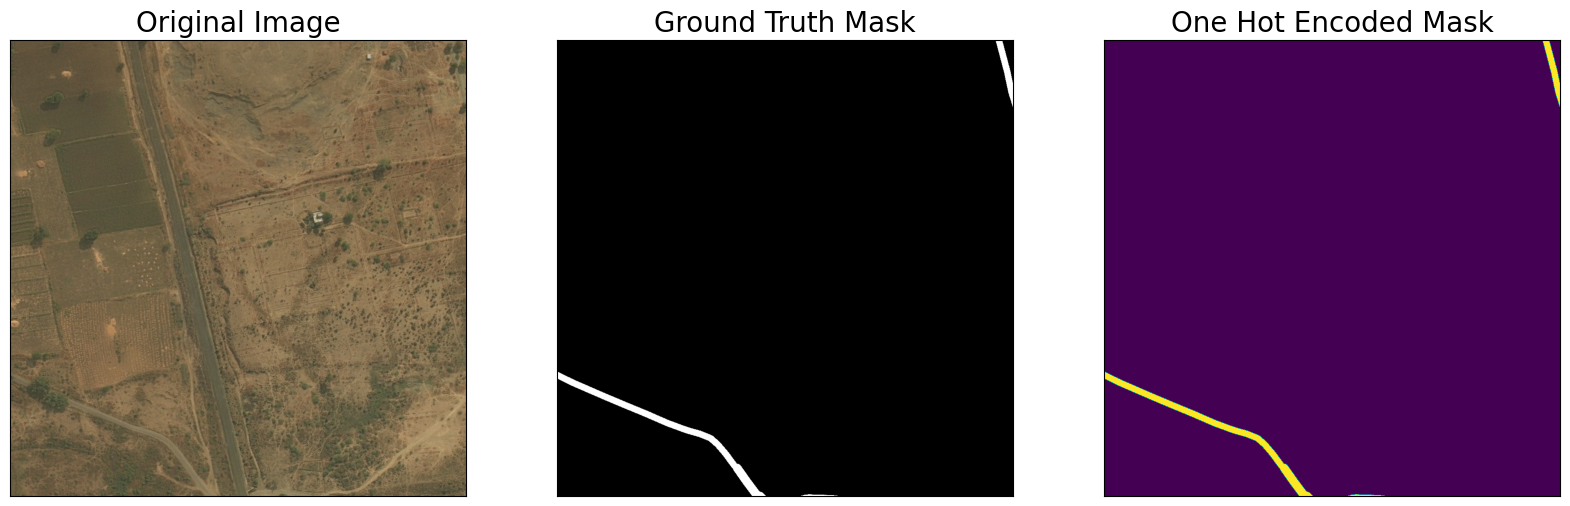

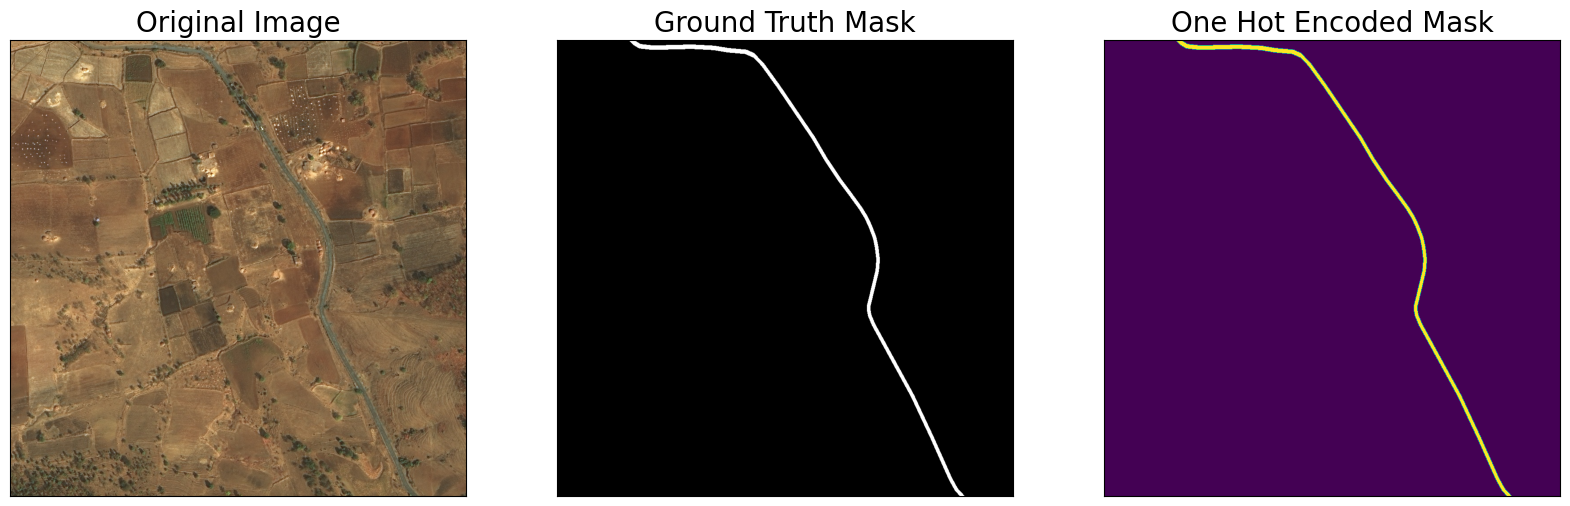

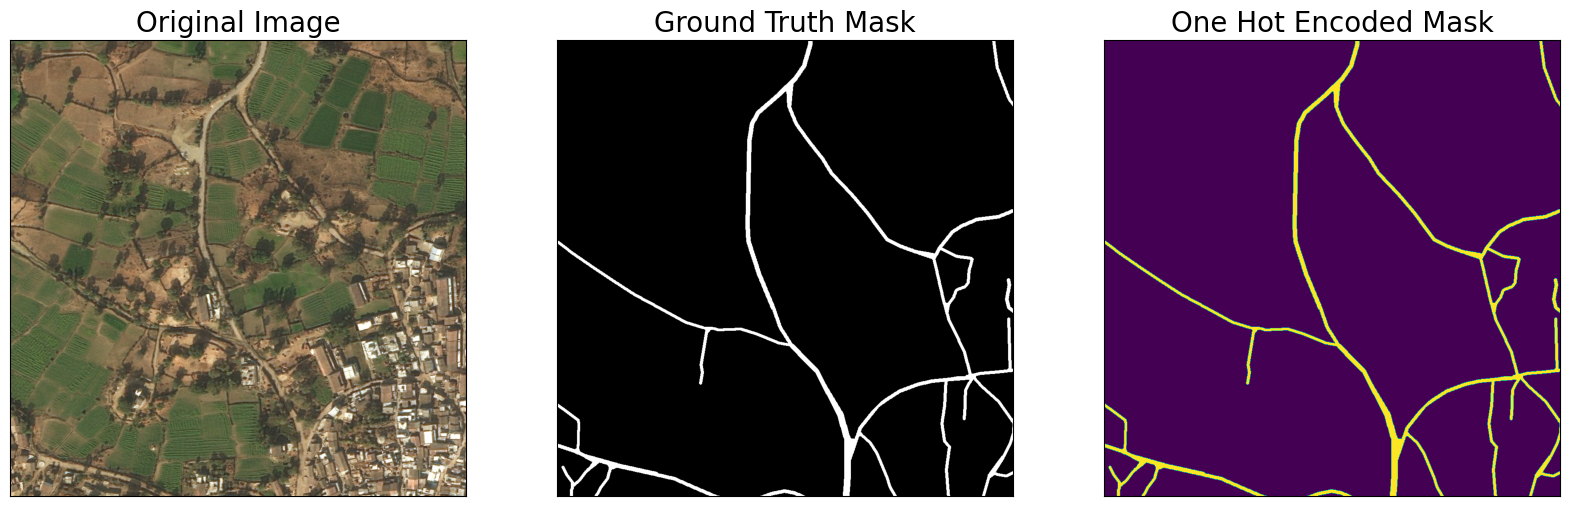

In [68]:
augmented_dataset = RoadsDataset(
    train_df,
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

for idx in range(3):
    image, mask = augmented_dataset[idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [69]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

In [70]:
import segmentation_models_pytorch as smp

In [71]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [72]:
train_dataset = RoadsDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = RoadsDataset(
    valid_df,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

In [73]:
INPUT_SIZE = (256, 256)
INPUT_SHAPE = (256, 256, 3)

In [74]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, Conv2DTranspose

def unet(input_shape, output_layer):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = Dropout(0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv2 = Dropout(0.1)(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv3 = Dropout(0.2)(conv3)

    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4 = Dropout(0.2)(conv4)

    # Bottom
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = Dropout(0.3)(conv5)

    # Decoder
    up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = Concatenate()([conv4, up6])
    conv6 = Dropout(0.2)(merge6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)
    conv6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
    conv6 = tf.keras.layers.BatchNormalization()(conv6)

    up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = Concatenate()([conv3, up7])
    conv7 = Dropout(0.2)(merge7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)
    conv7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
    conv7 = tf.keras.layers.BatchNormalization()(conv7)

    up8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = Concatenate()([conv2, up8])
    conv8 = Dropout(0.1)(merge8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = tf.keras.layers.BatchNormalization()(conv8)
    conv8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
    conv8 = tf.keras.layers.BatchNormalization()(conv8)

    up9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = Concatenate()([conv1, up9])
    conv9 = Dropout(0.1)(merge9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = tf.keras.layers.BatchNormalization()(conv9)
    conv9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
    conv9 = tf.keras.layers.BatchNormalization()(conv9)

    # Output
    output = Conv2D(output_layer, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=output)
    return model

In [75]:
model = unet(INPUT_SHAPE, output_layer=1)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 256, 16)         64        ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_20 (Conv2D)          (None, 256, 256, 16)         2320      ['batch_normalization_18

In [76]:
from tensorflow.keras.optimizers.legacy import Adam

In [77]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [89]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_masks, val_masks = train_test_split(image,mask,test_size=0.2, random_state=42)
train_images, test_images, train_masks, test_masks = train_test_split(train_images, train_masks, test_size=0.2, random_state=42)

In [90]:
train_images = [cv2.resize(img, (128, 128)) for img in train_images]
val_images = [cv2.resize(img, (128, 128)) for img in val_images]
test_images = [cv2.resize(img, (128, 128)) for img in test_images]

# Add channel dimension if images are grayscale
if train_images[0].ndim == 2: # Check if the image is grayscale
    train_images = [img[..., None] for img in train_images]  # Add channel dimension
    val_images = [img[..., None] for img in val_images]
    test_images = [img[..., None] for img in test_images]

# Convert lists back to numpy arrays
train_images = np.array(train_images)
val_images = np.array(val_images)
test_images = np.array(test_images)

In [91]:
print("Shape of train_images:", train_images.shape)
print("Shape of val_images:", val_images.shape)

Shape of train_images: (655, 128, 128, 1)
Shape of val_images: (205, 128, 128, 1)


In [92]:

epochs = 20
history = model.fit(train_images, train_masks, batch_size=16, epochs=epochs, validation_data=(val_images, val_masks))

Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 128, 128, 1)


In [93]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, epochs + 1)

# Plotting
plt.plot(epochs, train_accuracy, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

NameError: name 'history' is not defined

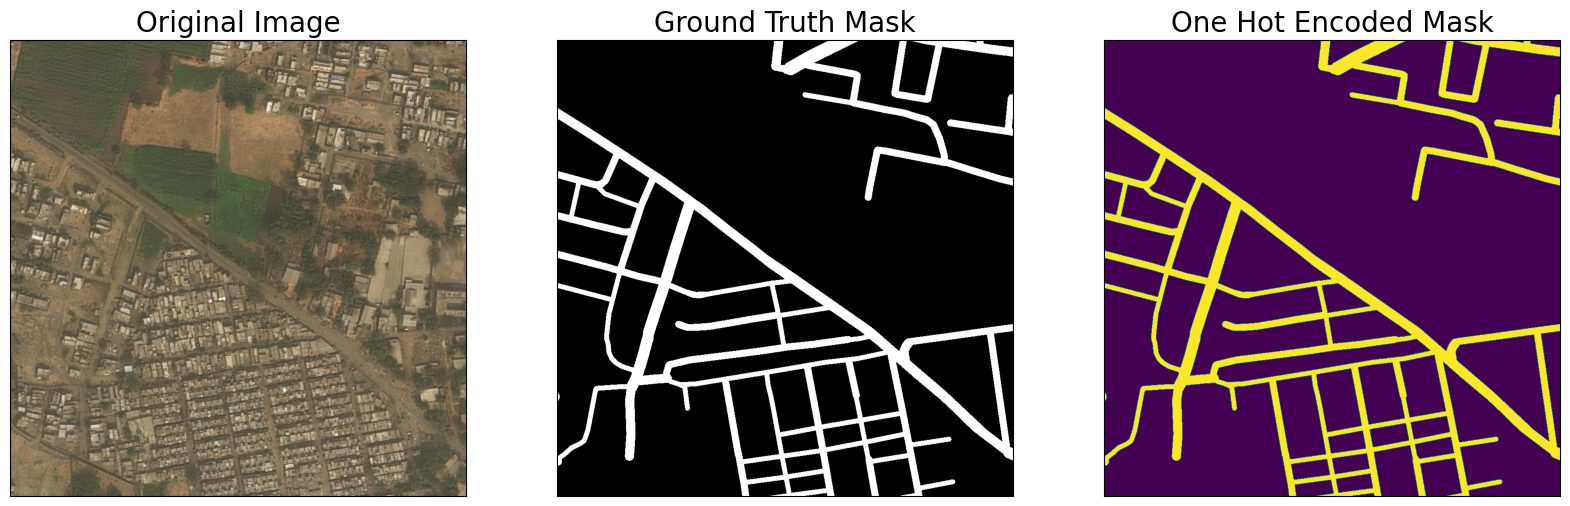

In [31]:
test_dataset = RoadsDataset(
    valid_df,
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = RoadsDataset(
    valid_df,
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)